## Classifying new Unlabeled Data with our Logistic Regression Model

### Import libraries

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, f1_score
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
tqdm.pandas()

Code to change progress bar color to dark from tqdm.

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  

Configuring the GPU

In [3]:
# GPU Configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use GPU 0
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPU


In [4]:
# Just a facy way of loading the data while being able to see the rows being loaded in real time. 
# Each value is in chunk size of 1000. So 2,471 chunks = 2,471,000 rows.
df = pd.DataFrame(pd.concat([chunk for chunk in tqdm(pd.read_csv('../data/reddit_depression_dataset_cleaned.csv', chunksize=1000, index_col=0), desc='Loading data')]))
df.head()

Loading data: 0it [00:00, ?it/s]

label                 date  upvotes  num_comments  \
0    0.0  2014-07-14 03:35:09      4.0           0.0   
1    0.0  2014-09-13 00:31:19      4.0           1.0   
2    0.0  2014-11-20 04:31:58      6.0           1.0   
3    0.0  2014-11-20 19:38:05     25.0           2.0   
5    0.0  2014-11-22 19:17:39      8.0          23.0   

                                       combined_text  \
0  Deep thoughts underdog Only when we start cons...   
1  I like this sub, there's only two posts yet I ...   
2  Rebirth! Hello. \nI am the new guy in charge h...   
3  "I want to be like water. I want to slip throu...   
5  What is the limit of the knowledge and power a...   

                                      tokenized_text  \
0  ['deep', 'thoughts', 'underdog', 'only', 'when...   
1  ['i', 'like', 'this', 'sub', ',', "there's", '...   
2  ['rebirth', '!', 'hello', '.', 'i', 'am', 'the...   
3  ['"', 'i', 'want', 'to', 'be', 'like', 'water'...   
5  ['what', 'is', 'the', 'limit', 'of', 'the', 'k...   

                                       alphanum_text  \
0  ['deep', 'thoughts', 'underdog', 'only', 'when...   
1  ['i', 'like', 'this', 'sub', 'only', 'two', 'p...   
2  ['rebirth', 'hello', 'i', 'am', 'the', 'new', ...   
3  ['i', 'want', 'to', 'be', 'like', 'water', 'i'...   
5  ['what', 'is', 'the', 'limit', 'of', 'the', 'k...   

                               stopword_removed_text  \
0  ['deep', 'thoughts', 'underdog', 'start', '99'...   
1  ['posts', 'coming', 'human', 'morality', 'joke...   
2  ['rebirth', 'guy', 'charge', 'thegood', 'ofc',...   
3  ['water', 'slip', 'fingers', 'hold', 'ship', '...   
5  ['limit', 'knowledge', 'power', 'human', 'pers...   

                                        stemmed_text  \
0  ['deep', 'thought', 'underdog', 'start', '99',...   
1  ['post', 'come', 'human', 'moral', 'joke', 'lo...   
2  ['rebirth', 'guy', 'charg', 'thegood', 'ofc', ...   
3  ['water', 'slip', 'finger', 'hold', 'ship', 'm...   
5  ['limit', 'knowledg', 'power', 'human', 'perso...   

                   non_stopword_removed_stemmed_text  \
0  ['deep', 'thought', 'underdog', 'onli', 'when'...   
1  ['i', 'like', 'thi', 'sub', 'onli', 'two', 'po...   
2  ['rebirth', 'hello', 'i', 'am', 'the', 'new', ...   
3  ['i', 'want', 'to', 'be', 'like', 'water', 'i'...   
5  ['what', 'is', 'the', 'limit', 'of', 'the', 'k...   

                               combined_stemmed_text  \
0  deep thought underdog start 99 underdog start ...   
1  post come human moral joke long abscenc hope d...   
2  rebirth guy charg thegood ofc bring weirdpinea...   
3         water slip finger hold ship michel william   
5     limit knowledg power human person infinit grow   

          combined_non_stopword_removed_stemmed_text  
0  deep thought underdog onli when we start consi...  
1  i like thi sub onli two post yet i keep come b...  
2  rebirth hello i am the new guy in charg here b...  
3  i want to be like water i want to slip through...  
5  what is the limit of the knowledg and power a ...

In [5]:
osm_df = pd.DataFrame(pd.concat([chunk for chunk in tqdm(pd.read_csv('../data/1.6_million_dataset_cleaned.csv', chunksize=1000), desc='Loading data')]))
osm_df.head()

Loading data: 0it [00:00, ?it/s]

date                                               text  \
0  2009-04-06 22:19:45  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1  2009-04-06 22:19:49  is upset that he can't update his Facebook by ...   
2  2009-04-06 22:19:53  @Kenichan I dived many times for the ball. Man...   
3  2009-04-06 22:19:57    my whole body feels itchy and like its on fire    
4  2009-04-06 22:19:57  @nationwideclass no, it's not behaving at all....   

                                        stemmed_text sentiment  
0  ['awww', 'bummer', 'shoulda', 'david', 'carr',...  Negative  
1  ['upset', 'updat', 'facebook', 'text', 'result...  Negative  
2  ['dive', 'time', 'ball', 'manag', 'save', '50'...  Negative  
3                          ['bodi', 'feel', 'itchi']  Negative  
4                                   ['behav', 'mad']  Negative

In [6]:
mhd_df = pd.DataFrame(pd.concat([chunk for chunk in tqdm(pd.read_csv('../data/mental_health_dataset_cleaned.csv', chunksize=1000), desc='Loading data')]))
mhd_df.head()

Loading data: 0it [00:00, ?it/s]

Date    location  likes  rt  followers  replies  \
0  2023-02-15 13:48:52+00:00   Haringey       5   1        317        0   
1  2023-02-09 22:37:56+00:00     unknown      0   0          9        0   
2  2022-10-20 11:30:07+00:00  Gloucester      0   0        905        0   
3  2022-10-18 19:42:14+00:00  Boston, MA      5   2      19257        0   
4  2022-10-18 19:42:13+00:00  Boston, MA      7   2      19257        1   

   engagement                                    processed_tweet  \
0    0.022082  people ocd experience intensely negative repet...   
1    0.000000  hello erika iocdf grassroots advocate loves ro...   
2    0.000000  light last week ocd awareness week wanted offe...   
3    0.000467  gifs million views giphy hope campaign shifts ...   
4    0.000727  ocdweek events activities livestreams led amaz...   

                                       stemmed_tweet sentiment  
0  ['peopl', 'ocd', 'experi', 'intens', 'neg', 'r...  Negative  
1  ['erika', 'iocdf', 'grassroot', 'advoc', 'love...  Positive  
2  ['light', 'week', 'ocd', 'awar', 'week', 'want...  Positive  
3  ['gif', 'view', 'giphi', 'hope', 'campaign', '...  Positive  
4  ['ocdweek', 'event', 'activ', 'livestream', 'l...  Positive

### Data Processing

In [7]:
df = df.dropna(subset=['combined_stemmed_text'])

In [8]:
osm_df.columns

Index(['date', 'text', 'stemmed_text', 'sentiment'], dtype='object')

In [9]:
df['date'] = pd.to_datetime(df['date'])
osm_df['date'] = pd.to_datetime(osm_df['date'])
mhd_df['Date'] = pd.to_datetime(mhd_df['Date'])

In [10]:
df['stemmed_text'] = df['stemmed_text'].progress_apply(ast.literal_eval)
osm_df['stemmed_text'] = osm_df['stemmed_text'].progress_apply(ast.literal_eval)
mhd_df['stemmed_tweet'] = mhd_df['stemmed_tweet'].progress_apply(ast.literal_eval)
print(type(df['stemmed_text'][0]))
print(type(osm_df['stemmed_text'][0]))
print(type(mhd_df['stemmed_tweet'][0]))

  0%|          | 0/1974821 [00:00<?, ?it/s]

  0%|          | 0/1600000 [00:00<?, ?it/s]

  0%|          | 0/724745 [00:00<?, ?it/s]

<class 'list'>
<class 'list'>
<class 'list'>


In [11]:
# Calculate the word counts for each row in 'non_stopword_removed_stemmed_text'
word_counts = df['non_stopword_removed_stemmed_text'].progress_apply(len)

  0%|          | 0/1974821 [00:00<?, ?it/s]

In [12]:
# Calculate the 80th percentile of word counts
percentile_80 = word_counts.quantile(0.80)

# Filter the dataframe to keep only rows with word counts less than or equal to the 80th percentile
df_non = df[word_counts <= percentile_80]

# Display the shape of the filtered dataframe
print(df_non.shape)
# Calculate the word counts for each row in 'non_stopword_removed_stemmed_text'
filtered_word_counts = df_non['non_stopword_removed_stemmed_text'].progress_apply(len)

(1580321, 12)


  0%|          | 0/1580321 [00:00<?, ?it/s]

### Model Preparation

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['stemmed_text'])
print(tokenizer.word_index)

{'feel': 1, 'peopl': 2, 'fuck': 3, 'day': 4, 'friend': 5, 'guy': 6, 'time': 7, 'girl': 8, 'post': 9, 'school': 10, 'talk': 11, 'life': 12, 'year': 13, 'thing': 14, 'good': 15, 'love': 16, 'today': 17, 'shit': 18, 'depress': 19, 'start': 20, 'hate': 21, 'happi': 22, 'die': 23, 'live': 24, 'person': 25, 'wanna': 26, 'bad': 27, 'thought': 28, 'work': 29, 'crush': 30, 'gonna': 31, 'play': 32, 'reddit': 33, '2': 34, 'sleep': 35, 'kill': 36, 'care': 37, 'edit': 38, 'parent': 39, 'sad': 40, 'dont': 41, 'hour': 42, 'game': 43, 'filler': 44, 'class': 45, 'teenag': 46, 'watch': 47, 'mom': 48, 'week': 49, 'comment': 50, 'lot': 51, 'want': 52, 'happen': 53, 'suicid': 54, 'month': 55, 'hope': 56, 'meme': 57, 'told': 58, 'pretti': 59, 'night': 60, '3': 61, 'bore': 62, 'final': 63, 'song': 64, 'hey': 65, 'long': 66, 'question': 67, 'ask': 68, 'kid': 69, 'boy': 70, 'turn': 71, 'idk': 72, 'think': 73, 'reason': 74, 'hard': 75, 'listen': 76, 'stuff': 77, 'nice': 78, 'famili': 79, 'tire': 80, 'girlfriend

In [14]:
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size:', vocab_size)

Vocabulary Size: 190286


In [15]:
sequences = tokenizer.texts_to_sequences(df['stemmed_text'])
max_length = max(len(seq) for seq in sequences)
print('Longest Sequence:', max_length)

Longest Sequence: 32


In [16]:
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
print('Padded Sequences Shape:', padded_sequences.shape)

Padded Sequences Shape: (1974821, 32)


In [17]:
X = padded_sequences
y = df['label']
print(X.shape, y.shape)

(1974821, 32) (1974821,)


In [18]:
X[0]

array([  578,    28, 16858,    20,  1841, 16858,    20,  2522,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0])

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1579856, 32) (1579856,)
(394965, 32) (394965,)


### Undersampling

In [20]:
X_sampling = pd.concat([pd.DataFrame(X_train).reset_index(drop=True), pd.DataFrame(y_train).reset_index(drop=True)], axis=1)
depressed = X_sampling[X_sampling['label'] == 1]
not_depressed = X_sampling[X_sampling['label'] == 0]
print(depressed.shape, not_depressed.shape)

(179707, 33) (1400149, 33)


In [21]:
not_depressed_downsampled = resample(not_depressed,
                                replace = False, # sample without replacement
                                n_samples = len(depressed)*3, # match minority n (3 times the minority class to keep as much data as possible)
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_depressed_downsampled, depressed])
print (downsampled.label.value_counts())

label
0.0    539121
1.0    179707
Name: count, dtype: int64


We do not want to lose too much data here.

In [22]:
downsampled_X_train = downsampled.drop('label', axis=1)
downsampled_y_train = downsampled['label']
downsampled_X_train = downsampled_X_train.to_numpy()
print(downsampled_X_train)

[[ 724  137  724 ...    0    0    0]
 [ 464    9  297 ...    0    0    0]
 [ 646   51 4862 ...    0    0    0]
 ...
 [  23   36 2400 ...    0    0    0]
 [  11    0    0 ...    0    0    0]
 [  99  775 1958 ...    0    0    0]]


### Model Building

In [23]:
with tf.device('/GPU:0'):
    model = Sequential([
        Embedding(vocab_size, 40, input_length=max_length),
        Dense(40, activation='sigmoid'),
        Dense(40, activation='sigmoid'),
        Dense(40, activation='sigmoid'),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    checkpoint_model = ModelCheckpoint('../data/model.weights.h5', save_weights_only=True, save_best_only=False)

    # We are using the downsampled model
    model.fit(downsampled_X_train, downsampled_y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
22464/22464 [==============================] - 108s 5ms/step - loss: 0.2274 - accuracy: 0.9097 - val_loss: 0.1539 - val_accuracy: 0.9443
Epoch 2/10
22464/22464 [==============================] - 106s 5ms/step - loss: 0.2027 - accuracy: 0.9203 - val_loss: 0.1783 - val_accuracy: 0.9372
Epoch 3/10
22464/22464 [==============================] - 107s 5ms/step - loss: 0.1987 - accuracy: 0.9220 - val_loss: 0.1577 - val_accuracy: 0.9440
Epoch 4/10
22464/22464 [==============================] - 105s 5ms/step - loss: 0.1963 - accuracy: 0.9228 - val_loss: 0.1793 - val_accuracy: 0.9369
Epoch 5/10
22464/22464 [==============================] - 106s 5ms/step - loss: 0.1944 - accuracy: 0.9237 - val_loss: 0.1585 - val_accuracy: 0.9438
Epoch 6/10
22464/22464 [==============================] - 106s 5ms/step - loss: 0.1927 - accuracy: 0.9245 - val_loss: 0.1652 - val_accuracy: 0.9414
Epoch 7/10
22464/22464 [==============================] - 106s 5ms/step - loss: 0.1911 - accuracy: 0.9250 - val_

In [24]:
def evaluate_model(model, X_test, y_test):
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    
    return accuracy, recall, f1, disp

12343/12343 [==============================] - 13s 1ms/step
Logistic Regression Model - Accuracy: 0.9410, Recall: 0.7960, F1 Score: 0.7543


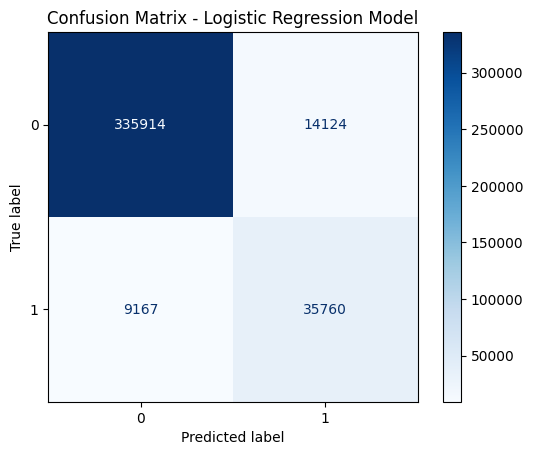

In [25]:
accuracy, recall, f1, disp = evaluate_model(model, X_test, y_test)
print(f"Logistic Regression Model - Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Logistic Regression Model')
plt.show()

### Model Application

In [26]:
# Preprocess the text data in osm_df
osm_sequences = tokenizer.texts_to_sequences(osm_df['stemmed_text'])
osm_padded_sequences = pad_sequences(osm_sequences, maxlen=max_length, padding='post')

# Apply the model to the preprocessed data
osm_predictions = (model.predict(osm_padded_sequences) > 0.5).astype("int32")

# Add the predictions to the dataframe
osm_df['predicted_label'] = osm_predictions

# Display the first few rows of the dataframe with predictions
osm_df.head()

50000/50000 [==============================] - 53s 1ms/step


date                                               text  \
0 2009-04-06 22:19:45  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1 2009-04-06 22:19:49  is upset that he can't update his Facebook by ...   
2 2009-04-06 22:19:53  @Kenichan I dived many times for the ball. Man...   
3 2009-04-06 22:19:57    my whole body feels itchy and like its on fire    
4 2009-04-06 22:19:57  @nationwideclass no, it's not behaving at all....   

                                        stemmed_text sentiment  \
0          [awww, bummer, shoulda, david, carr, day]  Negative   
1  [upset, updat, facebook, text, result, school,...  Negative   
2   [dive, time, ball, manag, save, 50, rest, bound]  Negative   
3                                [bodi, feel, itchi]  Negative   
4                                       [behav, mad]  Negative   

   predicted_label  
0                0  
1                0  
2                0  
3                0  
4                0

In [27]:
osm_df['predicted_label'].value_counts()

predicted_label
0    1546361
1      53639
Name: count, dtype: int64

In [28]:
osm_df[osm_df['predicted_label'] == 1].head()

date                                               text  \
16 2009-04-06 22:20:22  Hollis' death scene will hurt me severely to w...   
28 2009-04-06 22:20:56  ooooh.... LOL  that leslie.... and ok I won't ...   
29 2009-04-06 22:21:04  Meh... Almost Lover is the exception... this t...   
35 2009-04-06 22:21:20  ok I'm sick and spent an hour sitting in the s...   
77 2009-04-06 22:25:45                           No new csi tonight.  FML   

                                         stemmed_text sentiment  \
16  [holli, death, scene, hurt, sever, watch, film...  Negative   
28                     [oooh, lol, lesli, lesli, mad]  Negative   
29         [meh, lover, except, track, depress, time]  Negative   
35  [sick, spent, hour, sit, shower, sick, stand, ...  Negative   
77                                [csi, tonight, fml]  Negative   

    predicted_label  
16                1  
28                1  
29                1  
35                1  
77                1

In [29]:
osm_df[osm_df['predicted_label'] == 0].head()

date                                               text  \
0 2009-04-06 22:19:45  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1 2009-04-06 22:19:49  is upset that he can't update his Facebook by ...   
2 2009-04-06 22:19:53  @Kenichan I dived many times for the ball. Man...   
3 2009-04-06 22:19:57    my whole body feels itchy and like its on fire    
4 2009-04-06 22:19:57  @nationwideclass no, it's not behaving at all....   

                                        stemmed_text sentiment  \
0          [awww, bummer, shoulda, david, carr, day]  Negative   
1  [upset, updat, facebook, text, result, school,...  Negative   
2   [dive, time, ball, manag, save, 50, rest, bound]  Negative   
3                                [bodi, feel, itchi]  Negative   
4                                       [behav, mad]  Negative   

   predicted_label  
0                0  
1                0  
2                0  
3                0  
4                0

In [30]:
# Preprocess the text data in mhd_df
mhd_sequences = tokenizer.texts_to_sequences(mhd_df['stemmed_tweet'])
mhd_padded_sequences = pad_sequences(mhd_sequences, maxlen=max_length, padding='post')

# Apply the model to the preprocessed data
mhd_predictions = (model.predict(mhd_padded_sequences) > 0.5).astype("int32")

# Add the predictions to the dataframe
mhd_df['predicted_label'] = mhd_predictions

# Display the first few rows of the dataframe with predictions
mhd_df.head()

22649/22649 [==============================] - 23s 1ms/step


Date    location  likes  rt  followers  replies  \
0 2023-02-15 13:48:52+00:00   Haringey       5   1        317        0   
1 2023-02-09 22:37:56+00:00     unknown      0   0          9        0   
2 2022-10-20 11:30:07+00:00  Gloucester      0   0        905        0   
3 2022-10-18 19:42:14+00:00  Boston, MA      5   2      19257        0   
4 2022-10-18 19:42:13+00:00  Boston, MA      7   2      19257        1   

   engagement                                    processed_tweet  \
0    0.022082  people ocd experience intensely negative repet...   
1    0.000000  hello erika iocdf grassroots advocate loves ro...   
2    0.000000  light last week ocd awareness week wanted offe...   
3    0.000467  gifs million views giphy hope campaign shifts ...   
4    0.000727  ocdweek events activities livestreams led amaz...   

                                       stemmed_tweet sentiment  \
0  [peopl, ocd, experi, intens, neg, repetit, int...  Negative   
1  [erika, iocdf, grassroot, advoc, love, rockyou...  Positive   
2  [light, week, ocd, awar, week, want, offer, si...  Positive   
3  [gif, view, giphi, hope, campaign, shift, perc...  Positive   
4  [ocdweek, event, activ, livestream, led, amaz,...  Positive   

   predicted_label  
0                1  
1                0  
2                1  
3                0  
4                0

In [31]:
mhd_df['predicted_label'].value_counts()

predicted_label
0    577206
1    147539
Name: count, dtype: int64

In [32]:
mhd_df[mhd_df['predicted_label'] == 1].head()

Date    location  likes  rt  followers  replies  \
0  2023-02-15 13:48:52+00:00   Haringey       5   1        317        0   
2  2022-10-20 11:30:07+00:00  Gloucester      0   0        905        0   
9  2022-10-15 20:00:03+00:00     unknown      3   2       4377        0   
15 2022-10-15 00:05:26+00:00     unknown      9   0        558        0   
19 2022-10-14 19:51:19+00:00     unknown      0   0          2        0   

    engagement                                    processed_tweet  \
0     0.022082  people ocd experience intensely negative repet...   
2     0.000000  light last week ocd awareness week wanted offe...   
9     0.001599  miraculous immediately felt difference hear br...   
15    0.016129  know average takes years diagnosed ocd years g...   
19    0.000000  new video someone reached child ocd child choo...   

                                        stemmed_tweet sentiment  \
0   [peopl, ocd, experi, intens, neg, repetit, int...  Negative   
2   [light, week, ocd, awar, week, want, offer, si...  Positive   
9   [miracul, felt, differ, hear, brainsway, deep,...   Neutral   
15  [averag, take, year, diagnos, ocd, year, treat...  Positive   
19  [video, reach, child, ocd, child, choos, treat...  Positive   

    predicted_label  
0                 1  
2                 1  
9                 1  
15                1  
19                1

In [33]:
mhd_df[mhd_df['predicted_label'] == 0].head()

Date    location  likes  rt  followers  replies  \
1 2023-02-09 22:37:56+00:00     unknown      0   0          9        0   
3 2022-10-18 19:42:14+00:00  Boston, MA      5   2      19257        0   
4 2022-10-18 19:42:13+00:00  Boston, MA      7   2      19257        1   
5 2022-10-17 16:28:01+00:00  Boston, MA      5   2      19257        0   
6 2022-10-17 15:29:04+00:00     unknown      2   2       4377        0   

   engagement                                    processed_tweet  \
1    0.000000  hello erika iocdf grassroots advocate loves ro...   
3    0.000467  gifs million views giphy hope campaign shifts ...   
4    0.000727  ocdweek events activities livestreams led amaz...   
5    0.000467  catch last week ask experts livestream kevin a...   
6    0.001371  miss facebook livestream caleb lack ocd patien...   

                                       stemmed_tweet sentiment  \
1  [erika, iocdf, grassroot, advoc, love, rockyou...  Positive   
3  [gif, view, giphi, hope, campaign, shift, perc...  Positive   
4  [ocdweek, event, activ, livestream, led, amaz,...  Positive   
5  [catch, week, expert, livestream, kevin, ander...  Positive   
6  [facebook, livestream, caleb, lack, ocd, patie...  Negative   

   predicted_label  
1                0  
3                0  
4                0  
5                0  
6                0

### Export Data

In [34]:
osm_df.to_csv('../data/1.6_million_dataset_labelled_LogReg.csv', index=False)

In [35]:
mhd_df.to_csv('../data/mental_health_dataset_labelled_LogReg.csv', index=False)